# Analysis Deliverable
In this part of the project, we analyze our data, decide which factors should be included in our prediction model, and machine learn a likes-prediction model for Instagram posts made by popular singers.

## Analysis

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

First, we must read in the data, remove unnecessary columns and rows, and add relevant columns.

In [59]:
df_main = pd.read_json('../data/new/data.json')

Upon examining some visualizations, we discovered that there are some outliers that would skew our prediction model. These are data points with abnormally high follower counts. To account for this, we remove the top 10% quantile of posts, sorted by followers count.

In [60]:
df_main = df_main[df_main['followersCount'].between(df_main['followersCount'].quantile(0.0), df_main['followersCount'].quantile(0.9))]

The next set of rows to drop are ones whose users are not verified. We perform this filtering because we found that only a tiny percentage of the users were unverified, so, once again, we sacrificed some data points for better data consistency. Directly below is the justification.

In [61]:
# record non-verified information
df_nv = df_main[df_main['verified'] == False]
nv_posts = df_nv.shape[0]
df_nv = df_nv[['username']].groupby('username').count()
nv_count = df_nv.shape[0]
# record total information
tot_posts = df_main.shape[0]
tot_count = df_main['username'].value_counts(normalize=True).shape[0]
# calculate accounts ratios
r1 = nv_count / tot_count * 100
# calculate posts ratios
r2 = nv_posts / tot_posts * 100
# print out non-verified ratio
print("Only %{r1:.2f} of the accounts are non-verified, and only %{r2:.2f} of all posts are made by non-verified accounts. We chose to drop these values.".format(r1 = r1, r2 = r2))

Only %3.29 of the accounts are non-verified, and only %2.33 of all posts are made by non-verified accounts. We chose to drop these values.


And now we can proceed to drop those rows.

In [62]:
df_main = df_main[df_main['verified'] == True]

Next, we need a caption length column, as we believe caption length may potentially influence a post's number of likes. This column will hold the number of characters in each post's caption (0 if no caption).

In [63]:
df_main['captionLength'] = df_main['firstComment'].map(lambda x: 0 if x == None else len(x))

Lastly, we need a column containing the average number of likes received on posts by each user, for each of their posts in our dataset.

In [64]:
df_avglc = df_main[['likesCount', 'username']].groupby('username').mean().rename(columns={'likesCount': 'avglc'})
df_main = df_main.join(df_avglc, on='username')

Now, we can remove non-essential columns, or columns we will not be later using in analysis or machine learning. In particular, these are locationName, firstComment, url, imageUrl, verified, and followsCount.

In [65]:
df_main = df_main.drop(['firstComment', 'url', 'imageUrl', 'verified'], axis=1)

We must now add a column for normalized likes values for each post, so the likes counts of posts from users with varying followers counts can be roughly compared. To do this, we multiply the likes count by the proportion of likes count to the average likes count, and finally divide by followers count. We are aware of the bias present in this step, but our goal is to get a sense of the variables that may potentially affect our prediction model, not to prove correlation.

In [66]:
df_main['normalizedLikes'] = df_main['likesCount'] * df_main['likesCount'] / df_main['avglc'] / df_main['followersCount']

We will now add three indicator columns, one for the post's time of day, another for the day of the week on which the post was made, and a third for the month during which the post was made.

In [67]:
# time-of-day indicators
df_main['tod'] = df_main['timestamp'].map(
    lambda x: 'early' if 0 <= x.hour < 3 else
              'dawn' if 3 <= x.hour < 6 else
              'sunrise' if 6 <= x.hour < 9 else
              'morning' if 9 <= x.hour < 12 else
              'noon' if 12 <= x.hour < 15 else
              'afternoon' if 15 <= x.hour < 18 else
              'sunset' if 18 <= x.hour < 21 else
              'night')
# day of week indicators
df_main['dow'] = df_main['timestamp'].map(
    lambda x: 'sunday' if x.day_name() == 'Sunday' else
              'monday' if x.day_name() == 'Monday' else
              'tuesday' if x.day_name() == 'Tuesday' else
              'wednesday' if x.day_name() == 'Wednesday' else
              'thursday' if x.day_name() == 'Thursday' else
              'friday' if x.day_name() == 'Friday' else
              'saturday')
# month indicators
df_main['moy'] = df_main['timestamp'].map(
    lambda x: 'january' if x.month == 1 else
              'february' if x.month == 2 else
              'march' if x.month == 3 else
              'april' if x.month == 4 else
              'may' if x.month == 5 else
              'june' if x.month == 6 else
              'july' if x.month == 7 else
              'august' if x.month == 8 else
              'september' if x.month == 9 else
              'october' if x.month == 10 else
              'november' if x.month == 11 else
              'december')

Lastly, let's print out the first three rows of our updated dataframe to ensure our changes are correct.

In [68]:
df_main.head(3)

,username,timestamp,likesCount,followersCount,followsCount,isBusinessAccount,postsCount,captionLength,avglc,normalizedLikes,tod,dow,moy
631,lalalalisa_m,2020-04-04 10:30:14,4089329,30036100,0,False,515,43,3.800766e+06,0.146484,morning,saturday,april
632,lalalalisa_m,2020-04-02 04:29:49,3211096,30036100,0,False,515,0,3.800766e+06,0.090322,dawn,thursday,april
633,lalalalisa_m,2020-03-31 10:37:14,4085979,30036100,0,False,515,20,3.800766e+06,0.146244,morning,tuesday,march


Looks good! Let's proceed to do some analysis (and vizualization) to determine which variables will be worth considering in the machine learning phase.

### Followers Count

We believe that following size is potentially a factor in determining the number of likes a post will receive. In this section, we discover that the average likes-followers ratio (normalized likes value) decreases in an exponential fashion as the number of followers increases. This suggests that we should potentially treat our likes prediction model partially as poly-exponential function of the number of followers during the machine learning phase (note the logx=True parameter in fitting with seaborn's regplot).

In [69]:
# extract relevant columns
df_avgs = df_main[['username', 'followersCount', 'likesCount', 'normalizedLikes']]
# group by followers and take averages (note: followersCount does not change)
df_avgs = df_avgs.groupby('username').mean()
# print out df_avgs
df_avgs.head(3)

,followersCount,likesCount,normalizedLikes
username,,,
21savage,10886991.0,935330.583333,0.094565
50cent,25414459.0,188473.329966,0.012633
5sos,8129347.0,228757.916667,0.031106


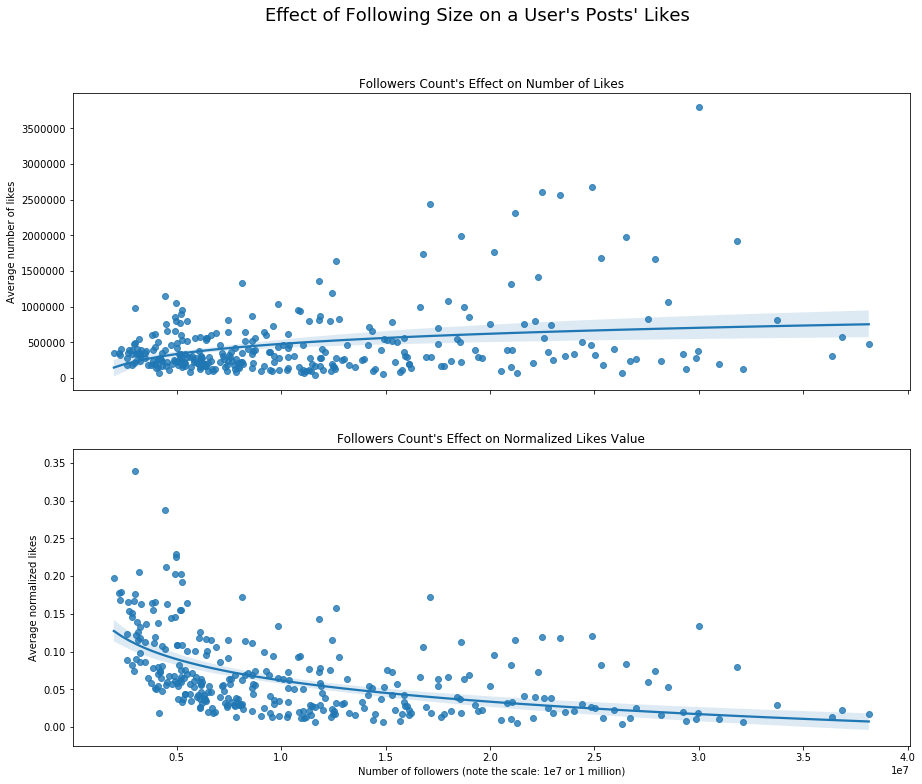

In [70]:
# create two plots showing the effect of followers count on likes count
fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
sns.regplot(x=df_avgs['followersCount'], y=df_avgs['likesCount'], ax=axes[0], logx=True)
sns.regplot(x=df_avgs['followersCount'], y=df_avgs['normalizedLikes'], ax=axes[1], logx=True)
axes[0].set_title('Followers Count\'s Effect on Number of Likes')
axes[0].set_xlabel('')
axes[0].set_ylabel('Average number of likes')
axes[1].set_title('Followers Count\'s Effect on Normalized Likes Value')
axes[1].set_ylabel('Average normalized likes')
plt.xlabel('Number of followers (note the scale: 1e7 or 1 million)')
fig.suptitle('Effect of Following Size on a User\'s Posts\' Likes', fontsize=18)
plt.show()

Double check relation using logarithmic manipulation and linear regression. We are expecting a negative slope...

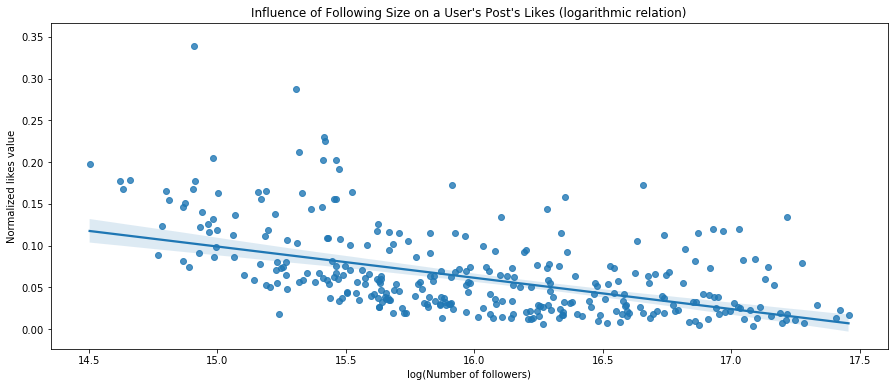

In [71]:
# show the same two graphs at a smaller scale
plt.figure(figsize=(15, 6))
sns.regplot(x=df_avgs['followersCount'].map(np.log), y=df_avgs['normalizedLikes'], robust=True)
plt.title('Influence of Following Size on a User\'s Post\'s Likes (logarithmic relation)')
plt.xlabel('log(Number of followers)')
plt.ylabel('Normalized likes value')
plt.show()

... and it looks somewhat acceptable! There is still some curvature in the data, suggesting that we may be observing a poly-exponential relation between followers count and the normalized likes value. This means that the relation between followers count and likes count may also be poly-exponential.

### Caption Length

We believe the length of a post's caption may influence the number of likes it receives. In this section, no clear relation was found between caption length and likes count for a post, but a slight negative exponential relation (revealed in Lowess regression) is possibly existent. Unfortunately, there is too much noise in the data to be sure. This suggests we should try including caption length in the machine learning phase, but it is unlikely to contribute much to the prediction task, and we may likely remove it from our final list of parameters.

In [72]:
# group by caption length
df_caps = df_main[['captionLength', 'normalizedLikes']]
df_caps = df_caps.groupby('captionLength').mean().reset_index()
# print df_caps
df_caps.head(3)

,captionLength,normalizedLikes
0,0,0.052307
1,1,0.060137
2,2,0.064217


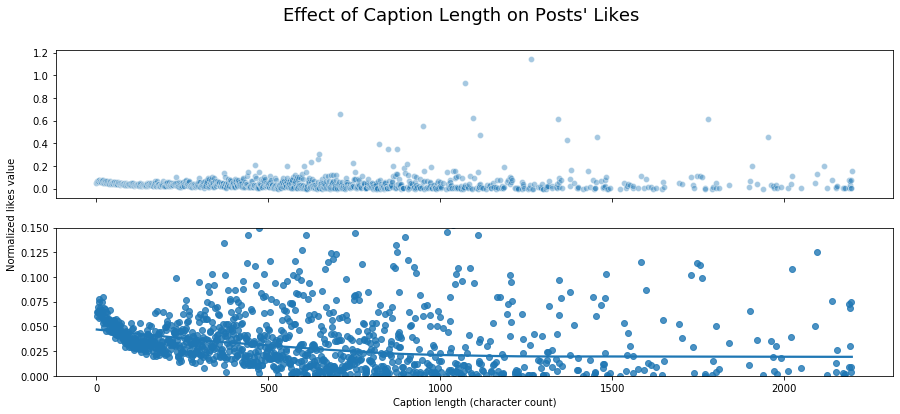

<Figure size 1080x432 with 0 Axes>

In [73]:
# plot the scatter and show logarithmic relation, note that the first row had to be dropped
fig, axes = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
plt.figure(figsize=(15, 6))
sns.scatterplot(x=df_caps['captionLength'], y=df_caps['normalizedLikes'], alpha=0.4, ax=axes[0])
sns.regplot(x=df_caps[1:]['captionLength'], y=df_caps[1:]['normalizedLikes'], lowess=True, ax=axes[1])
axes[0].set_ylabel('')
axes[1].set_xlabel('Caption length (character count)')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 0.15)
fig.suptitle('Effect of Caption Length on Posts\' Likes', fontsize=18)
fig.text(0.08, 0.5, 'Normalized likes value', rotation='vertical', va='center')
plt.show()

Double check exponential relation using logarithmic manipulation and linear regression.

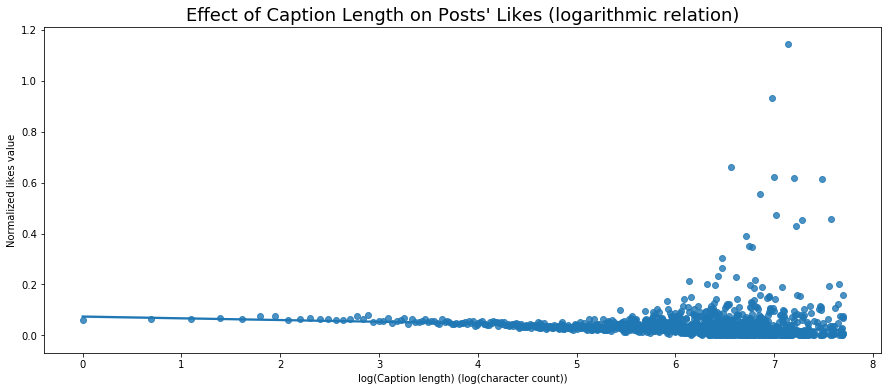

In [74]:
# plot the logarithmic relation between caption length and likes count
plt.figure(figsize=(15, 6))
sns.regplot(x=df_caps[1:]['captionLength'].map(np.log), y=df_caps[1:]['normalizedLikes'], robust=True)
plt.title('Effect of Caption Length on Posts\' Likes (logarithmic relation)', fontsize=18)
plt.xlabel('log(Caption length) (log(character count))')
plt.ylabel('Normalized likes value')
plt.show()

The negative trend is more pronounced in this example, but the data still seems to "fan out" as the caption length increases, just as was observed in the original data. Despite the higher variance on the right hand side, this still provides a stronger case for including caption length in the machine learning phase.

### Time of Day
We believe that the time of day when the post was made was may effect the number of likes it receives. In this section, we discovered that certain times (UTC) had higher average normalized likes values than other times, but most of the posts tended to be made when this value was to be lower. The trends suggest that using a waking/sleeping hour indicator may be a good alternative to dividing the day up into three hours chunks.

In [80]:
todorder = ['early', 'dawn', 'sunrise', 'morning', 'noon', 'afternoon', 'sunset', 'night']
todtimes = ['0:00-2:59', '3:00-5:59', '6:00-8:59', '9:00-11:59', '12:00-14:59', '15:00-17:59', '18:00-20:59', '21:00-23:59']
posts = [df_main[df_main['tod'] == tod].shape[0] for tod in todorder]
avg_likes = [df_main[df_main['tod'] == tod][['tod', 'normalizedLikes']].groupby('tod').mean()['normalizedLikes'][0] for tod in todorder]

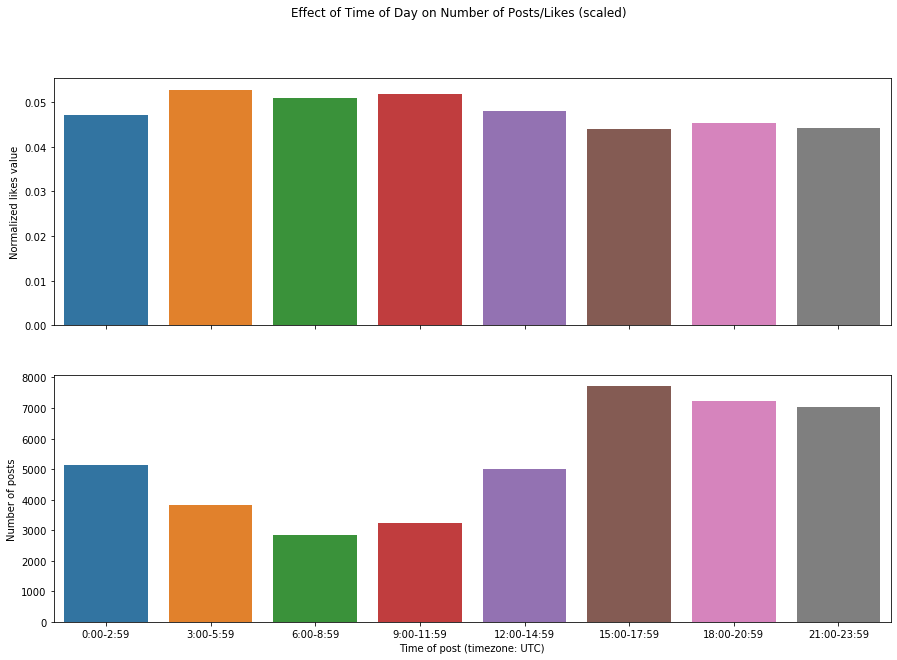

In [81]:
# plot the effect of time of day on number of posts/likes
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
sns.barplot(x=todorder, y=avg_likes, ax=axes[0])
sns.barplot(x=[tim for tim in todtimes], y=posts, ax=axes[1])
plt.xlabel('Time of post (timezone: UTC)')
axes[0].set_ylabel('Normalized likes value')
# axes[0].set_ylim(0.04, 0.06)
axes[1].set_ylabel('Number of posts')
# axes[1].set_ylim(1000, 4000)
fig.suptitle('Effect of Time of Day on Number of Posts/Likes (scaled)')
plt.show()

### Day of Week
We believe what day of the week when the post was made was may effect the number of likes it receives. In this section, we discovered that the normalized likes value tends to be higher on the weekend, but the number of posts throughout the week stays relatively constant. This suggests that instead of using a day of week indicator, it may be worth using simply a weekday/weekend indicator.

In [82]:
doworder = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
posts = [df_main[df_main['dow'] == dow].shape[0] for dow in doworder]
avg_likes = [df_main[df_main['dow'] == dow][['dow', 'normalizedLikes']].groupby('dow').mean()['normalizedLikes'][0] for dow in doworder]

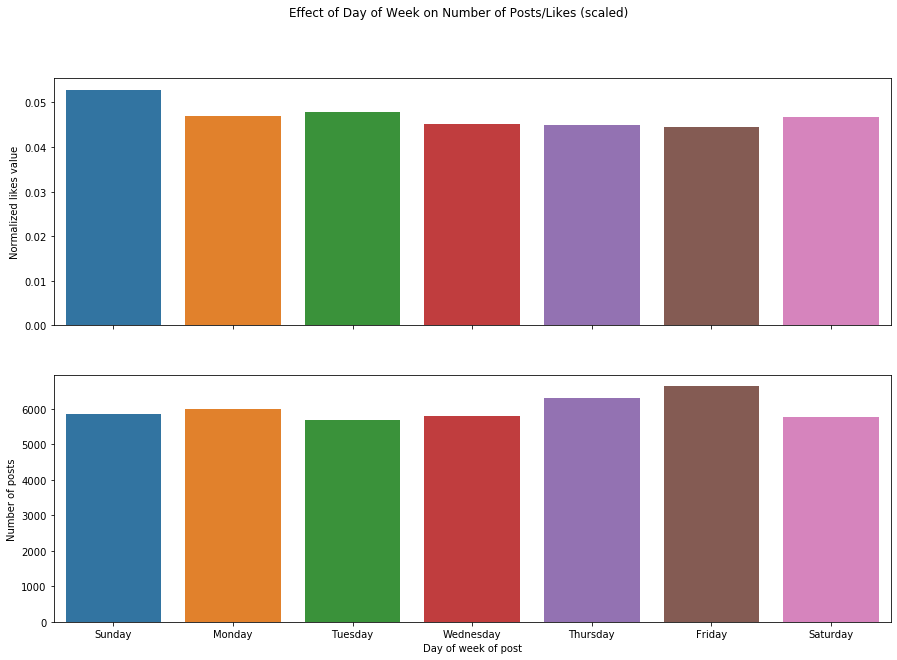

In [83]:
# plot the effect of day of week on the number of posts/likes
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
sns.barplot(x=doworder, y=avg_likes, ax=axes[0])
sns.barplot(x=[dow.title() for dow in doworder], y=posts, ax=axes[1])
plt.xlabel('Day of week of post')
axes[0].set_ylabel('Normalized likes value')
# axes[0].set_ylim(0.045,0.055)
axes[1].set_ylabel('Number of posts')
# axes[1].set_ylim(2500, 3500)
fig.suptitle('Effect of Day of Week on Number of Posts/Likes (scaled)')
plt.show()

### Month of Year
We believe that the time of the year (month) when the post was made was may effect the number of likes it receives. In this section, we discovered

In [84]:
moyorder = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
posts = [df_main[df_main['moy'] == moy].shape[0] for moy in moyorder]
avg_likes = [df_main[df_main['moy'] == moy][['moy', 'normalizedLikes']].groupby('moy').mean()['normalizedLikes'][0] for moy in moyorder]

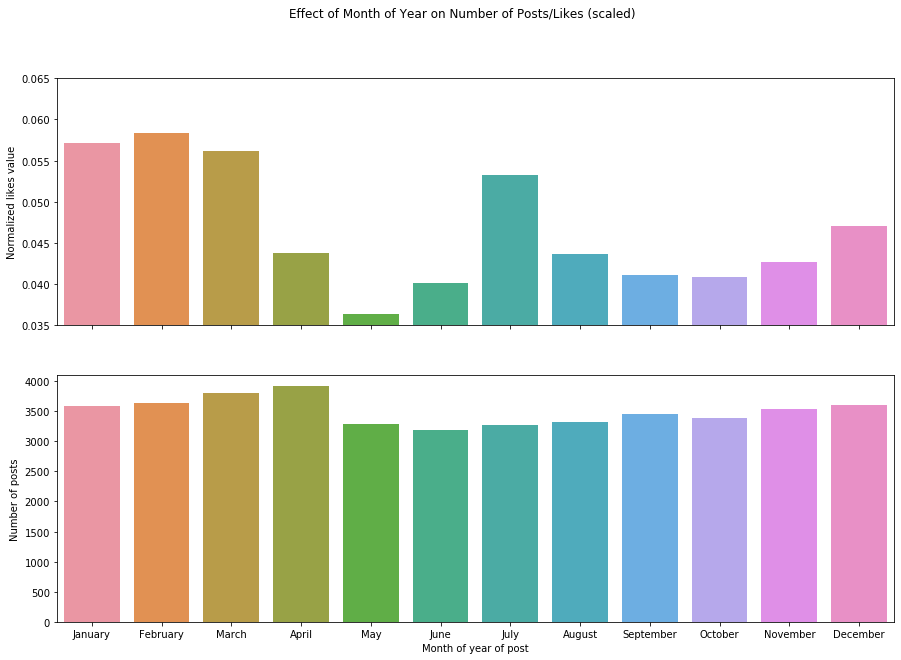

In [85]:
# plot the effect of month of year on the number of posts/likes
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
sns.barplot(x=moyorder, y=avg_likes, ax=axes[0])
sns.barplot(x=[moy.title() for moy in moyorder], y=posts, ax=axes[1])
plt.xlabel('Month of year of post')
axes[0].set_ylabel('Normalized likes value')
axes[0].set_ylim(0.035, 0.065)
axes[1].set_xlabel
axes[1].set_ylabel('Number of posts')
fig.suptitle('Effect of Month of Year on Number of Posts/Likes (scaled)')
plt.show()

### Average Number of Likes
We believe that the average number of likes received on a user's past posts is a powerful indicator of the number likes a new post will receive.

## Training The Model
In this section, we train the model and adjust it based on the results summaries.

In [88]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import eval_measures
from sklearn.model_selection import train_test_split, cross_val_score

In [91]:
X = df_main[['avglc', 'followersCount', 'captionLength', 'tod', 'dow', 'moy']]
y = df_main['likesCount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# train model
train_set = X_train['likesCount'] = y_train
eq = "likesCount ~ avglc + followersCount + captionLength + tod + dow + moy"
model = smf.ols(formula=eq, data=df_main)
# add constant
# sm.add_constant(X_train)
# sm.add_constant(X_test)
# model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()
# print out model results
train_predictions = results.predict(X_train)
test_predictions = results.predict(X_test)
print("R-Squared: ", results.rsquared)
print("Training MSE: ", eval_measures.mse(y_train, train_predictions))
print("Testing MSE: ", eval_measures.mse(y_test, test_predictions))

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


R-Squared:  0.6304155631659678
Training MSE:  59781149577.05585
Testing MSE:  59966887643.69206


## Next Steps
1. Tweak model to improve r-squared & decrease MSE
2. Implement k-fold cross validation to increase consistency
3. Use newly scraped data
4. Add image classification data
5. Add target audience time zones & adjust times